### Observing alpha 
 
 In this notebook I will attempt to efficiently calculate and observe the optimal step size  during a training loop derived as: 
 
$\alpha^*=\frac{-d^{\top} g}{d^{\top} H d}$
 

In [2]:
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector
from torch.nn.utils import vector_to_parameters  # this is NOT inverse of params_to_vector, see cell below
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from warnings import warn
import matplotlib.pyplot as plt
import numpy as np
from backpack import backpack, extend
from backpack.extensions import (
    GGNMP,
    HMP,
    KFAC,
    KFLR,
    KFRA,
    PCHMP,
    BatchDiagGGNExact,
    BatchDiagGGNMC,
    BatchDiagHessian,
    BatchGrad,
    BatchL2Grad,
    DiagGGNExact,
    DiagGGNMC,
    DiagHessian,
    SqrtGGNExact,
    SqrtGGNMC,
    SumGradSquared,
    Variance,
)

# Load the MNIST dataset: As tensor and normalized to average = 0.1307; variance = 0.3081
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # apply transformation
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) # Mischen nach jedem Durchlauf
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


In [4]:
def vector_to_parameter_list(vec, parameters):
    """Convert the vector `vec` to a parameter-list format matching
    `parameters`. This function is the inverse of `parameters_to_vector` from
    `torch.nn.utils`. In contrast to `vector_to_parameters`, which replaces the
    value of the parameters, this function leaves the parameters unchanged and
    returns a list of parameter views of the vector.

    Args:
        vec (torch.Tensor): The vector representing the parameters. This vector
            is converted to a parameter-list format matching `parameters`.
        parameters (iterable): An iterable of `torch.Tensor`s containing the
            parameters. These parameters are not changed by the function.

    Raises:
        Warning if not all entries of `vec` are converted.
    """

    if not isinstance(vec, torch.Tensor):
        raise TypeError(f"`vec` should be a torch.Tensor, not {type(vec)}.")

    # Put slices of `vec` into `params_list`
    params_list = []
    pointer = 0
    for param in parameters:
        num_param = param.numel()
        params_list.append(
            vec[pointer: pointer + num_param].view_as(param).data
        )
        pointer += num_param

    # Make sure all entries of the vector have been used (i.e. that `vec` and
    # `parameters` have the same number of elements)
    if pointer != len(vec):
        warn("Not all entries of `vec` have been used.")

    return params_list

In [6]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),  # Input size is 784 (28x28), hidden layer size is 128
            nn.ReLU(),
            nn.Linear(128, 64),   # Second hidden layer size is 64
            nn.ReLU(),            # Kein softmax, da das in pytorch in nn.CrossEntropyLoss verrechnet wird (numerisch stabiler)
            nn.Linear(64, 10)     # Output layer for 10 classes: Kein softmax, da das in pytorch in nn.CrossEntropyLoss
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = SimpleNet()
model = extend(model, use_converter=True) # Extend the loss function

In [8]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    alpha_values = []  # store the alpha values
    alpha_values_unnormed = []
    percentages = []
    loss_values = []
    max_num_batches = 50    # only for testing, remove later
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Break the loop after the specified number of batches
        # if batch_idx >= max_num_batches - 1:
        #   break
        
        # save current parameters
        theta_0 = parameters_to_vector(model.parameters())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimization
        with backpack(
        GGNMP(),
            ):
            loss.backward()
            
        # Extract gradients and convert to a vector
        gradients = parameters_to_vector(param.grad for param in model.parameters() if param.grad is not None)
        
        gradients_normalized = gradients / torch.norm(gradients)
        
        optimizer.step()
        
        
        d_unnormalized = parameters_to_vector(model.parameters()) - theta_0 # direction of adjustment
        
        d_normalized = d_unnormalized / torch.norm(d_unnormalized)          # normalized direction of adjustment
    
        d = vector_to_parameter_list(d_normalized, model.parameters())      # in shape of params (expected by ggnmp)
        
        ggnmp = [p.ggnmp for p in model.parameters()]        # extract ggnmp functions (per each bias and weights)
        
        H_times_d = []  # result list
        
        
        for d,ggnmp in zip(d, ggnmp):
            H_times_d.append(ggnmp(d))    # holds the result of H*d for each parameter (6 in this network)
        
        H_times_d_vec = parameters_to_vector(H_times_d)
        
        denom = torch.dot(H_times_d_vec, d_normalized) # denominator: d^T*(H*d) using d_normed
        
        denom_unnormed = torch.dot(H_times_d_vec, d_unnormalized) # using d_unnormed
        
        numerator = - torch.dot(gradients, d_normalized)  # numerator: - d^T*g 
        
        numerator_unnormed = - torch.dot(gradients, d_unnormalized)
        
        
        alpha = numerator / denom
        
        alpha_unnormed = numerator_unnormed / denom_unnormed
         
        alpha_values.append(alpha)
        
        alpha_values_unnormed.append(alpha_unnormed)
        
        loss_values.append(loss.item())
        
        position = 0 # only for printing, I print different positions of the data each time
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            percentages.append(batch_idx / len(train_loader))
                               
            # print("Current parameter vector length:", len(theta_0), ", values:", theta_0[position:position + 5])  # observe a different position each time
            # print("d vector unnormalized length:", len(d_unnormalized), "norm:", torch.norm(d_unnormalized), "\n values:", d_unnormalized[position:position + 5])
            # print("d vector normalized length:", len(d_normalized), ", norm:", torch.norm(d_normalized), "\n values:", d_normalized[position:position + 5])
            # print("gradients vector length:", len(gradients), "\n values:", gradients[position:position + 5])
            # print("H*d length:", len(H_times_d), "\n values: ", H_times_d[position])
            # print("H*d vector shape:", H_times_d_vec.shape)
            # print("denominator:", denom, "numerator:", numerator)
            # print("alpha with d normalized: ", alpha, ", alpha with d unnormalized:", alpha_unnormed)                  
                               
        total_params = sum(p.numel() for p in model.parameters()) # only for printing
        position = (position + 5) % total_params
    
    # Convert alpha values from list to a tensor
    alpha_values_tensor = torch.tensor(alpha_values)
    alpha_unnormed_tensor = torch.tensor(alpha_values_unnormed)
    loss_tensor = torch.tensor(loss_values)
    
    # Split alpha values into chunks of size 10
    alpha_chunks = alpha_values_tensor.chunk(len(alpha_values_tensor) // 10)
    alpha_unnormed_chunks = alpha_unnormed_tensor.chunk(len(alpha_values_unnormed) // 10)
    loss_chunks = loss_tensor.chunk(len(loss_tensor) // 10)

    # Calculate average alpha values for each chunk, this gives back a list
    avg_alpha_values = [chunk.mean() for chunk in alpha_chunks]
    avg_alpha_unnormed_values = [chunk.mean() for chunk in alpha_unnormed_chunks]
    avg_loss_values = [chunk.mean() for chunk in loss_chunks]
    
    # print(type(avg_alpha_values))
    
    # convert back to tensor
    avg_alpha_values_tensor = torch.tensor(avg_alpha_values)
    avg_alpha_unnormed_values_tensor = torch.tensor(avg_alpha_unnormed_values)
    avg_loss_values_tensor = torch.tensor(avg_loss_values)
    
    # plot loss
    plt.plot(loss_tensor.detach().numpy())
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title(f"Loss Over Epoch {epoch}")
    plt.show()

    # Plot alpha values
    plt.plot(alpha_values_tensor.detach().numpy())
    # Add vertical lines for each percentage
    plt.xlabel("Batch")
    plt.ylabel("Alpha Value")
    plt.title(f"Alpha Values Over Epoch {epoch}")
    plt.show()
    
    # plot smoothened loss
    plt.plot(avg_loss_values_tensor.detach().numpy())
    plt.xlabel("Chunk")
    plt.ylabel("Average Loss (each 10 batches)")
    plt.title(f"Smoothened Loss Over Epoch {epoch}")
    plt.show()
    
    # Plot average alpha values
    plt.plot(avg_alpha_values_tensor.detach().numpy())
    plt.xlabel("Chunk")
    plt.ylabel("Average Alpha Value (each 10 batches)")
    plt.title(f"Smoothened Alpha Values Over Epoch {epoch}")
    plt.show()
    
    print(type(alpha_values))
    print(len(alpha_values))
    
    return alpha_values, loss_values, avg_alpha_values, avg_loss_values
    
        
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')


In [10]:
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
model.to(device)

# Set up optimizer and loss function
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
criterion = extend(criterion) # for backpack

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301957
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.365623
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.294750
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.060704
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.250685
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.172888
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.149484
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.063966
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.128297
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.113191


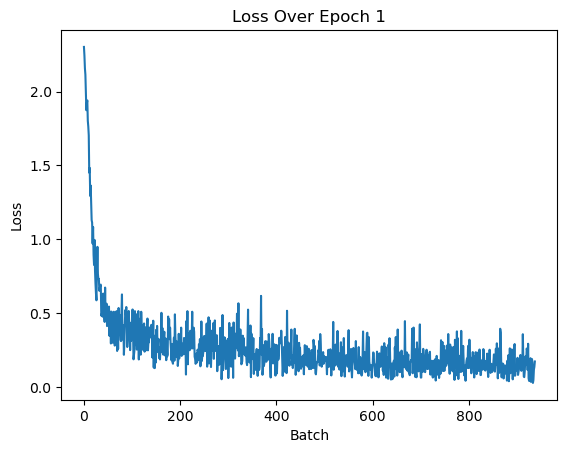

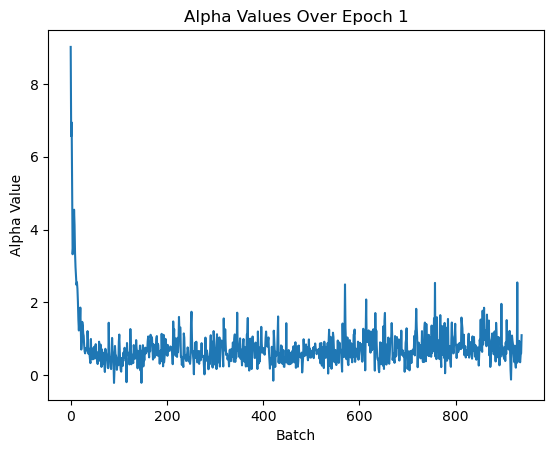

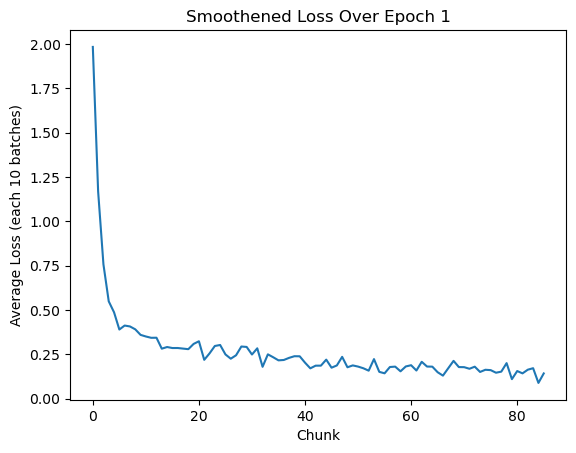

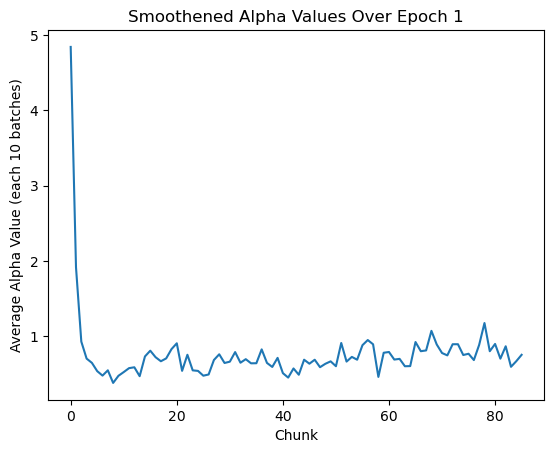

<class 'list'>
938
938
Complete Alphas length: 1
Complete Loss length: 1

Test set: Average loss: 0.0001, Accuracy: 9539/10000 (95.39%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.193206
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.162096
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.219931
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.047992
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.093716
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.237433
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.102094
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.069157
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.106079
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.037280


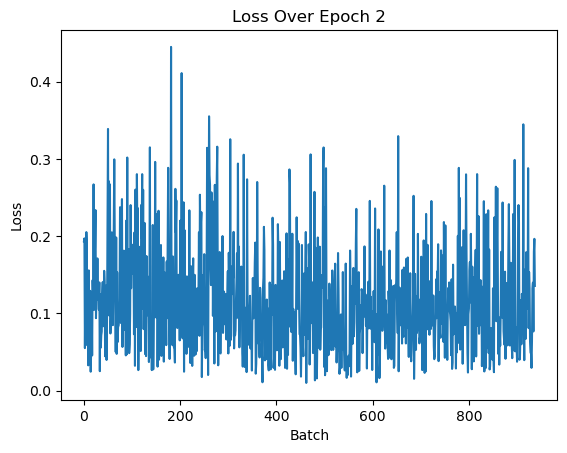

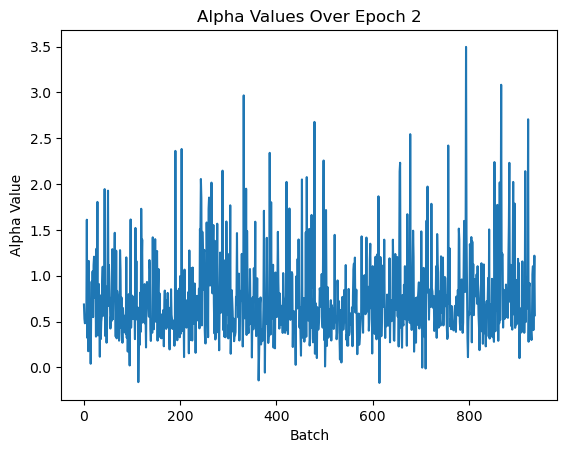

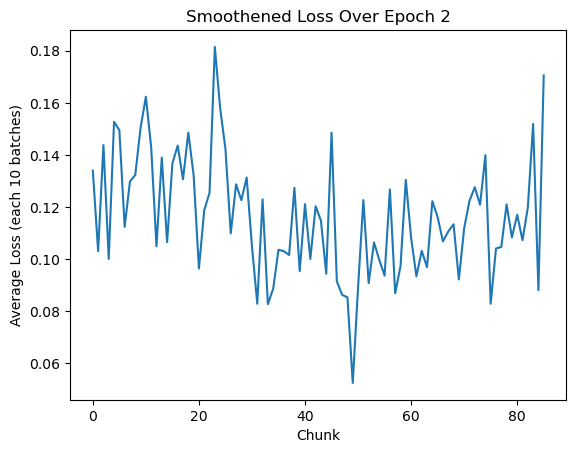

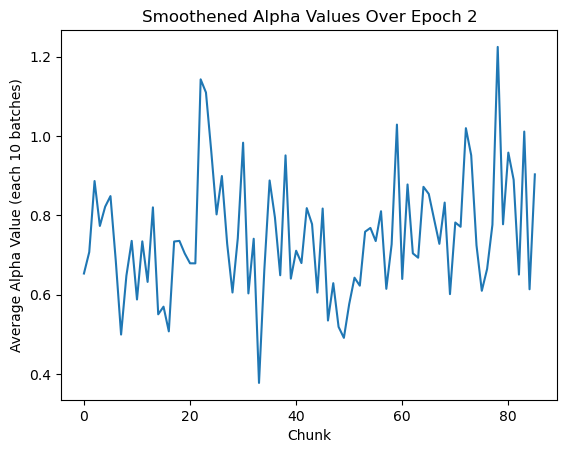

<class 'list'>
938
938
Complete Alphas length: 2
Complete Loss length: 2

Test set: Average loss: 0.0001, Accuracy: 9626/10000 (96.26%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.148890
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.099629
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.037195
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.030839
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.095045
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.032654
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.113809
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.028310
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.141281
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.077676


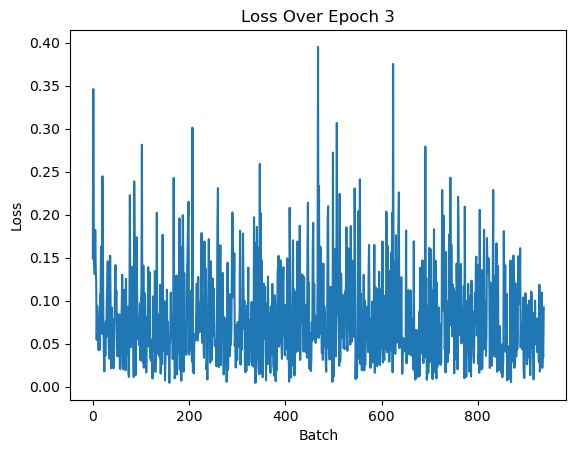

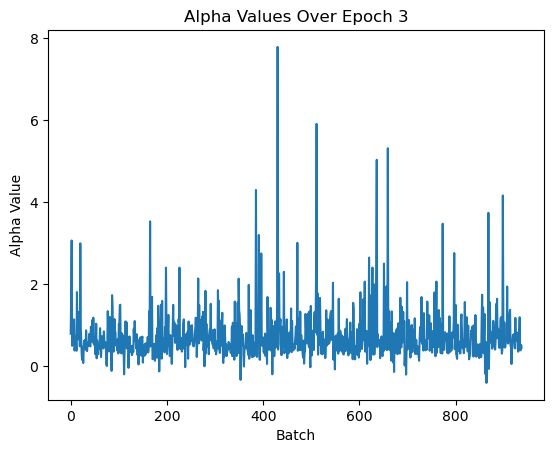

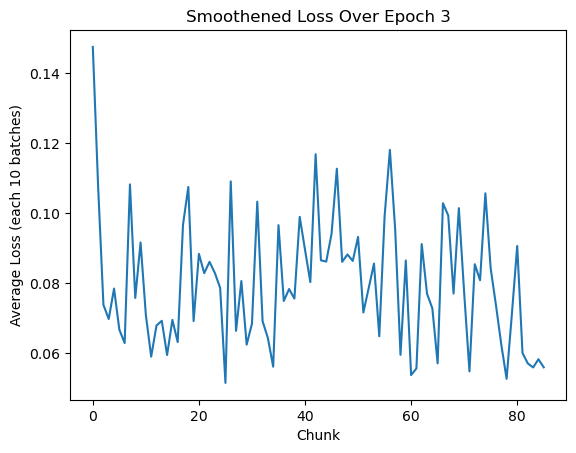

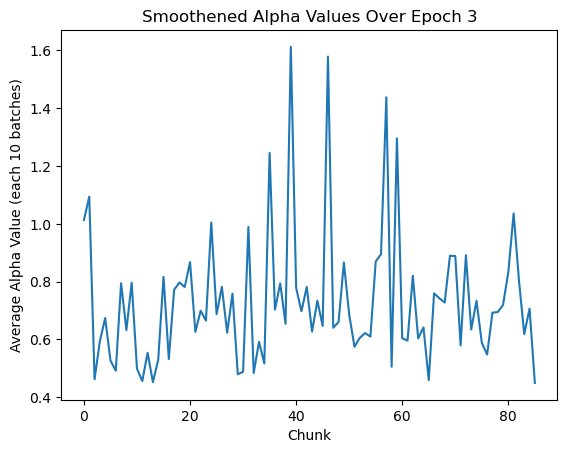

<class 'list'>
938
938
Complete Alphas length: 3
Complete Loss length: 3

Test set: Average loss: 0.0001, Accuracy: 9735/10000 (97.35%)

3


In [12]:
# Number of epochs
num_epochs = 3
complete_alphas = []
complete_loss = []
complete_avg_alphas = []
complete_avg_losses = []

# Training and testing loop
for epoch in range(1, num_epochs + 1):
    alpha_values, loss_values, avg_alpha_values, avg_loss_values = train(model, device, train_loader, optimizer, criterion, epoch)
    
    print(len(alpha_values))
    complete_alphas.append(alpha_values)
    complete_loss.append(loss_values)
    complete_avg_alphas.append(avg_alpha_values)
    complete_avg_losses.append(avg_loss_values)
    
    # Check lengths after appending
    print(f"Complete Alphas length: {len(complete_alphas)}")
    print(f"Complete Loss length: {len(complete_loss)}")
    
    test(model, device, test_loader, criterion)

print(len(complete_alphas))







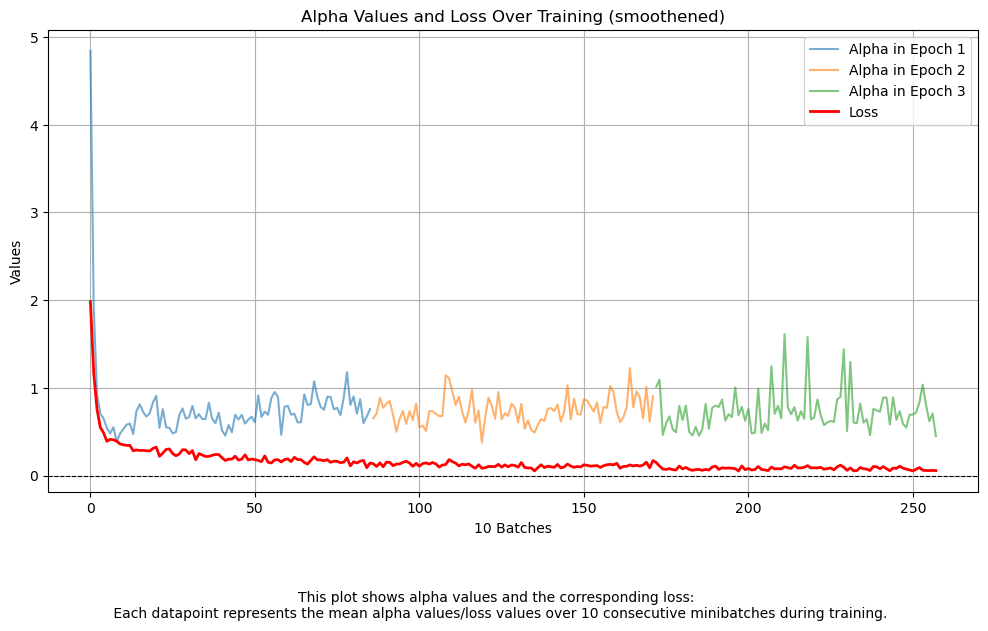

In [13]:

def plot_results(complete_alphas, complete_losses):
    """ 
    Takes lists of alphas and losses for each epoch and plots them.
    """
    plt.figure(figsize=(12, 6))

    # Initialize the starting index for x-values
    start_index = 0
    
    # Plot alpha values for each epoch
    for epoch_idx, alphas in enumerate(complete_alphas):
        # Convert the current epoch alphas to numpy for plotting
        alphas_np = np.array([a.detach().numpy() for a in alphas])  # Detach if they're tensors
        
        # Create x-values for the current epoch
        x_values = np.arange(start_index, start_index + len(alphas_np))
        
        # Plot alpha values for the current epoch
        plt.plot(x_values, alphas_np, label=f'Alpha in Epoch {epoch_idx + 1}', alpha=0.6)
        
        # Update the starting index for the next epoch
        start_index += len(alphas_np)

    # Plot losses
    losses_flattened = [loss for sublist in complete_losses for loss in sublist]
    x_losses = np.arange(len(losses_flattened))  # x-values for losses
    plt.plot(x_losses, losses_flattened, label='Loss', color='red', linewidth=2)

    # Adding details to the plot
    plt.xlabel("10 Batches")
    plt.ylabel("Values")
    plt.title("Alpha Values and Loss Over Training (smoothened)")
    plt.axhline(0, color='black', lw=0.8, ls='--')  # Add a horizontal line at y=0 for reference
    plt.legend()
    plt.grid(True)
    # Adding explanation below the plot using figtext
    plt.figtext(0.5, -0.1, 
                "This plot shows alpha values and the corresponding loss: \n Each datapoint represents the mean alpha values/loss values over 10 consecutive minibatches during training.", 
                ha='center', fontsize=10)
    
    plt.show()



plot_results(complete_avg_alphas, complete_avg_losses)